# Brian Tutorial
## Instructors: Dan Goodman and Marcel Stimberg

Date: 7/8/2020

### Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np



In [2]:
import brian2 as b2
import brian2tools as b2t

In [3]:
b2.prefs.codegen.target = 'numpy' # Not as fast but easier for compatibility

## Nice Brian properties
Brian has nice unit operations to help reduce dimension mismatches.

In [4]:
3000*b2.mV+1*b2.volt # Brian has dimensions

4. * volt

### Adding Wrong units
Brian will not add together variables with different untils like:

__3000*b2.mV+1*b2.nA # Different units will not add__

## Simple Leaky Integrate and Fire Example

The leaky integrate and fire neuron is defined the equations:
$$ \tau \frac{dV}{dt}=-V $$
where V is neuronal activity and $\tau$ is the leak rate set to $10ms$, with the initial value of $V=0.5$.

###  Start simualtion

In [5]:
b2.start_scope()

In [6]:
tau=10*b2.ms # Set Tau

Define the integrate and fire model

In [7]:
eqs='''
dV/dt = -V/tau : 1 # This defines the equation and the units can be set to b2.volt
'''

### Neuron Setup
Setup the neuron using the **Brian** function **NeuroGroup**.

In [8]:
G=b2.NeuronGroup(1,
                 eqs,
                 method='exact',
                 dt=0.001*b2.ms) # 
G.V=0.5

### Monitor Activity
Define what to activity to monitor using the **Brian** function **StateMonitor**.

In [9]:
M=b2.StateMonitor(G,'V',record=True) # Record all information

### Run Code
Simulate 100ms of acivity using the **Brian** function **run**.

In [10]:
b2.run(100*b2.ms) # Do a 100 ms recording

### Plotting Activity
Plot the activity using the **brian2tools** function **brian_plot**.

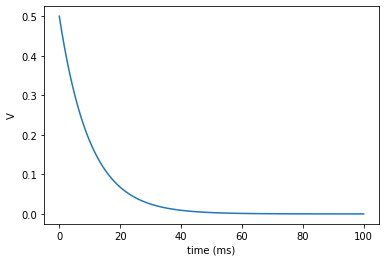

In [11]:
b2t.brian_plot(M) # Plot results

## Leaky Integrate and Fire with Sinusoisal Input

The leaky integrate and fire neuron with sinusoidal input is defined by the equation:
$$  \frac{dv}{dt}=\frac{(10\sin(2\pi f t)-v) }{\tau}$$
where V is neuronal activity and $\tau$ is the leak rate set to $10ms$, with the initial value of $V=0.5$.
With a threshold of $v=1$ and a reset value $v=0$.

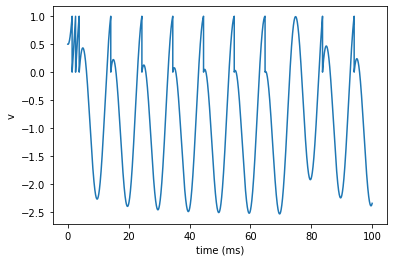

In [12]:
b2.start_scope()
f=100*b2.Hz
tau=10*b2.ms
# This defines the equation and the units can be set to b2.volt
eqs='''
dv/dt = (10*sin(2*pi*f*t)-v)/tau : 1 
'''

G=b2.NeuronGroup(1,eqs,method='euler',dt=0.001*b2.ms,threshold='v>1',reset='v=0')
# Threshold introduces the spike threshold and the reset can be anything but
G.v=0.5
M=b2.StateMonitor(G,'v',record=True)


b2.run(100*b2.ms)
b2t.brian_plot(M)

## Leaky Integrate and Fire with Sinusoisal Input with changing reset value

The leaky integrate and fire neuron with sinusoidal input is defined by the equation:
$$  \frac{dv}{dt}=\frac{(10\sin(2\pi f t)-v) }{\tau}$$
with a changeing threshold defined by the equation:
$$  \frac{dv_t}{dt}=\frac{(1-v_t) }{\tau_t}$$
where $v$ is neuronal activity and $\tau$ is the leak rate set to $10ms$ and leak reset rate $\tau_t=50ms$, with the initial values of $v=0.5$ and $v_t=1$.
With a threshold of $v=1$ and a reset value that is a function of $v_t$.

In [13]:
b2.start_scope()
f=100*b2.Hz
tau=10*b2.ms
tau_t=50*b2.ms


eqs='''
dv/dt = (10*sin(2*pi*f*t)-v)/tau : 1 # This defines the equation and the units can be set to b2.volt
dvt/dt=(1-vt)/tau_t:1
'''

G=b2.NeuronGroup(1,eqs,method='euler',dt=0.001*b2.ms,threshold='v>vt',reset='v=0;vt+=0.5')
# Threshold introduces the spike threshold and the reset can be anything but
G.v=0.5
G.vt=1
M=b2.StateMonitor(G,'v',record=True) # Monitor Neuronal activity
Mt=b2.StateMonitor(G,'vt',record=True) # Monitor refractory activity


b2.run(100*b2.ms)

Plot below shows the neuronal activity $v$ and the refractory activity $v_t$.

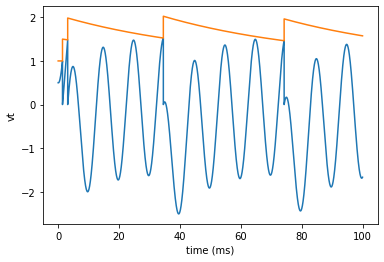

In [14]:
b2t.brian_plot(M)
b2t.brian_plot(Mt)

## Including a Refactory period
Set a refractory period between spikes using the **Brian** function **NeuroGroup**.
The leaky integrate and fire neuron with a constant input $2$:
$$  \frac{dv}{dt}=\frac{(2-v) }{\tau}$$
with a changeing threshold defined by the equation:
$$  \frac{dv_t}{dt}=\frac{(1-v_t) }{\tau_t}$$
where $v$ is neuronal activity and $\tau$ is the leak rate set to $10ms$ and leak reset rate $\tau_t=50ms$, with the initial values of $v=0.5$ and $v_t=1$.
With a threshold of $v=1$ and a reset value that is a function of $v_t$.

In [15]:
b2.start_scope()

tau = 10*b2.ms
tau_t = 50*b2.ms
f = 100*b2.Hz
eqs = '''
dv/dt = (2-v)/tau : 1 (unless refractory)
dvt/dt = (1-vt)/tau_t : 1
'''
G = b2.NeuronGroup(1, eqs,
                threshold='v>vt',
                reset='v=0; vt += 0.5',
                refractory=2*b2.ms,
                method='euler')
G.vt = 1

M = b2.StateMonitor(G, ('v', 'vt'), record=True)
spM = b2.SpikeMonitor(G)

b2.run(100*b2.ms)

Plot on the left below shows the neuronal activity $v$ and the refractory activity $v_t$. The plot on the right shows the spikes for this neuron (this is known as a raster plot).

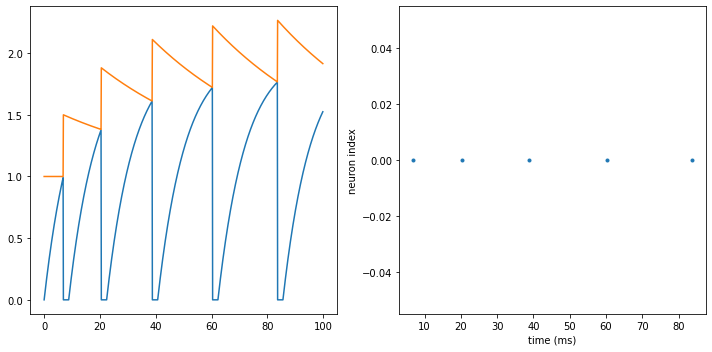

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(M.t/b2.ms, M.v[0])
plt.plot(M.t/b2.ms, M.vt[0])
plt.subplot(122)
b2t.brian_plot(spM)
plt.tight_layout()

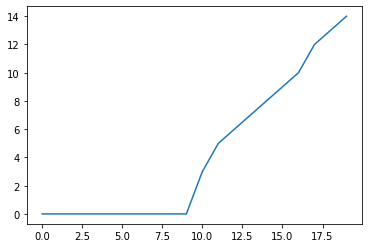

In [17]:
b2.start_scope()
I_values=np.linspace(0,2,20)
counts=[]
eqs=''' dv/dt=(I-v)/tau:1'''
G=b2.NeuronGroup(1,eqs,threshold='v>1',reset='v=0',method='exact')
M=b2.SpikeMonitor(G)
b2.store()

for I in I_values:
    b2.restore()
    tau=10*b2.ms
    b2.run(100*b2.ms)
    counts.append(M.num_spikes)
    
plt.plot(counts)

## Building a 100 neuron Unconected Network
Start with the setup of the equations as before.
The leaky integrate and fire neuron with a constant input $I$:
$$  \frac{dv}{dt}=\frac{(I-v) }{\tau}$$
with a changeing threshold defined by the equation:
$$  \frac{dv_t}{dt}=\frac{(1-v_t) }{\tau_t}$$
where $v$ is neuronal activity and $\tau$ is the leak rate set to $10ms$ and leak reset rate $\tau_t=50ms$, with the initial values of $v=0.5$ and $v_t=1$.
With a threshold of $v=1$ and a reset value that is a function of $v_t$.

In [18]:
b2.start_scope()

tau = 10*b2.ms
tau_t = 50*b2.ms
f = 100*b2.Hz
eqs = '''
dv/dt = (I-v)/tau : 1 (unless refractory)
dvt/dt = (1-vt)/tau_t : 1
I:1
'''

To extend the model to 100 neurons is very simple using the **Brian** function **NeuroGroup** just specify the number 100.

In [19]:
G = b2.NeuronGroup(100, eqs,
                threshold='v>vt',
                reset='v=0; vt += 0.5',
                refractory=2*b2.ms,
                method='euler')
G.vt = 1

Each neuron has different input to illustrate to highlight each neuron in the plot.
The input linearly increase as a function of the position (order) of the neuron with respect to the first one
$$ I=\frac{3i}{N},$$
where $i$ is the neuron index and $N$ is the total number of neurons. These are pre-defined variables in **Brian** so avoid using them.

In [20]:
G.I='3*i/(1.0*N)' # i is the index of the Neuron N is the neuron number
# avoid using i and N in equations

WARNING    "I" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 2.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


To reduce the amount of data recorded use the **Brian** function **SpikeMonitor**.

In [21]:
M = b2.StateMonitor(G, ('v', 'vt'), record=[1,98]) # Only monitor two neurons 2 and 99
spM = b2.SpikeMonitor(G)

b2.run(100*b2.ms)

The plot below shows the activity for two neurons and their refractory activity on the left. The right panel shows spiking activity for each neuron in the network.

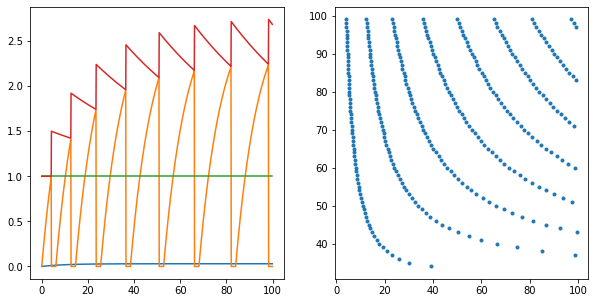

In [22]:
## Plotting
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(M.t/b2.ms, M.v[:].T)
plt.plot(M.t/b2.ms, M.vt[:].T)
plt.subplot(122)
#b2t.brian_plot(spM)
plt.plot(spM.t/b2.ms,spM.i,'.') # same as brian_plot

## Building a 100 neuron Unconected Network with Noise
To illustrate the 
The leaky integrate and fire neuron with an input $I$ and noise $\Xi$:
$$  \frac{dv}{dt}=\frac{(I-v) }{\tau}+0.3\Xi\tau^{-0.5}$$
with a changeing threshold defined by the equation:
$$  \frac{dv_t}{dt}=\frac{(1-v_t) }{\tau_t}$$
where $v$ is neuronal activity and $\tau$ is the leak rate set to $10ms$ and leak reset rate $\tau_t=50ms$, with random initial values of $v$ and $v_t=1$.
With a threshold of $v=1$ and a reset value that is a function of $v_t$.
$\xi$ is a pre-defined variables in **Brian**.

In [23]:
b2.start_scope() # THIS IGNORES everything from before

tau = 10*b2.ms
tau_t = 50*b2.ms
f = 100*b2.Hz
# xi in brian a special 

eqs = '''
dv/dt = (I-v)/tau +0.3*xi*tau**-0.5: 1 (unless refractory)
dvt/dt = (1-vt)/tau_t : 1
I:1
'''
G = b2.NeuronGroup(100, eqs,
                threshold='v>vt',
                reset='v=0; vt += 0.5',
                refractory=2*b2.ms,
                method='euler')
G.vt = 1
G.v= 'rand()' # This gives a random initial condition 
G.I='3*i/(1.0*N)' # i is the index of the Neuron N is the neuron number
# avoid using i and N in equations
M = b2.StateMonitor(G, ('v', 'vt'), record=[1,98]) # Only on neuron
spM = b2.SpikeMonitor(G)

b2.run(100*b2.ms)

WARNING    "I" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 2.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


The plot below shows the activity for two neurons and their refractory activity on the left. The right panel shows spiking activity for each neuron in the network.

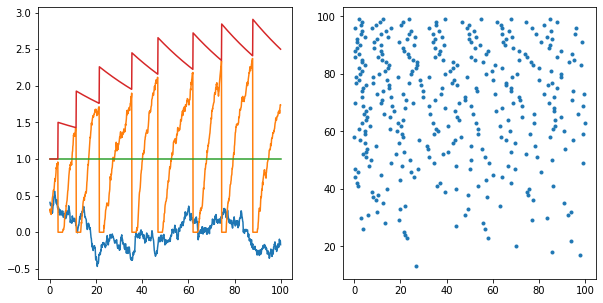

In [24]:
## Plotting
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(M.t/b2.ms, M.v[:].T)
plt.plot(M.t/b2.ms, M.vt[:].T)
plt.subplot(122)
#b2t.brian_plot(spM)
plt.plot(spM.t/b2.ms,spM.i,'.') # same as brian_plot

In [25]:
from brian2 import *
from brian2tools import *

## Firing Rates
To simulate simple random firing rates in **Brian** define and equation with term **rates** which is shared accross all neurons.
The code and plot below shows a raster plot for 200ms with a changing firing rate every 50ms. 

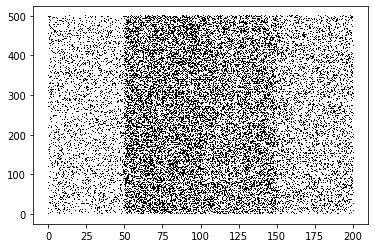

In [26]:
start_scope()
eqs='''
rates: Hz (shared)
'''

G=NeuronGroup(500,eqs,threshold='rand()<rates*dt')
M=SpikeMonitor(G)

for _ in range(4):
    G.rates= '500*rand()*Hz'

    run(50*ms) # first 50ms 100Hz
plot(M.t/ms,M.i,',k')


Instead of using a for loop to simulate a raster plot for 200ms with a changing firing rate every 50ms. 

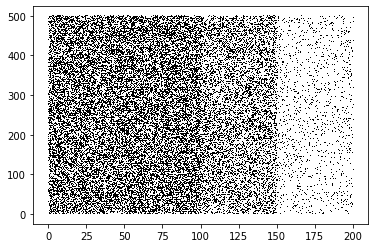

In [27]:

start_scope()
eqs='''
rates: Hz (shared)
'''

G=NeuronGroup(500,eqs,threshold='rand()<rates*dt')
M=SpikeMonitor(G)

G.run_regularly('rates=rand()*500*Hz',dt=50*ms)
run(200*ms)
plot(M.t/ms,M.i,',k')

Another way of doing the same simulation.

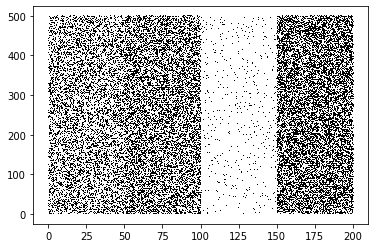

In [28]:
start_scope()
eqs='''
rates: Hz (shared)
'''

G=NeuronGroup(500,eqs,threshold='rand()<rates*dt')
M=SpikeMonitor(G)
@network_operation(dt=50*ms)
def change_rates():
    G.rates=rand()*500*Hz
run(200*ms)
plot(M.t/ms,M.i,',k')

## Poisson Firing
To simulate Poisson firing there is a predefined function in **Brain** called **PoissonGroup**. The plot below shows a raster plot for 100 neurons with a Poirsson firing rate of 100Hz for 100ms.

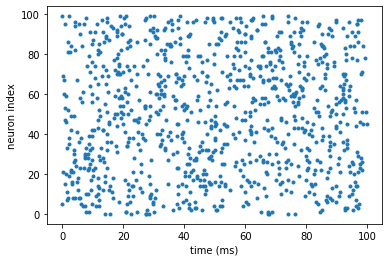

In [29]:
start_scope()
G=PoissonGroup(100,rates=100*Hz)
M=SpikeMonitor(G)

run(100*ms)
brian_plot(M)

The raster plot below illustrates 100 neurons with  Poisson firing with a firing rate of 100Hz for 50ms and then 250Hz for 50ms.

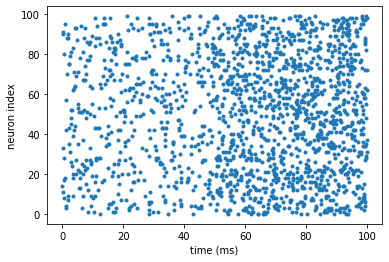

In [30]:
start_scope()
G=PoissonGroup(100,rates=100*Hz)
M=SpikeMonitor(G)

run(50*ms) # first 50ms 100Hz
G.rates=250*Hz
run(50*ms) # second 50ms 250Hz
brian_plot(M)

The plot below illustrates another way of implementing different Poisson firing rates. The plot has different random Poisson firing rates every 50ms.

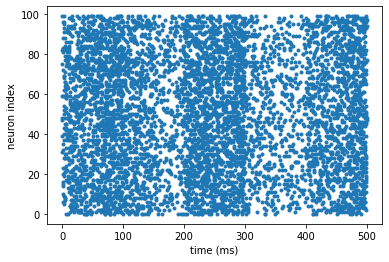

In [31]:
start_scope()
G=PoissonGroup(100,rates=100*Hz)
M=SpikeMonitor(G)
for _ in range(10):
    G.rates=200*rand()*Hz

    run(50*ms) # first 50ms 100Hz
brian_plot(M)

# Synapses and Connections
To simulate a neural network neurons need to be connected.

In [32]:
start_scope()
eqs = '''
dv/dt = (I-v)/(10*ms) : 1
I : 1
'''
G = NeuronGroup(2, eqs, threshold = 'v>1', reset = 'v=0')
G.I = [1.5,0]

Using the **Brian** function **Synapses** to deving the intereaction of the neurons and then then connecting the two neurons using **connect**.

INFO       No numerical integration method specified for group 'neurongroup_2', using method 'exact' (took 0.03s). [brian2.stateupdaters.base.method_choice]
WARNING    "I" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 2.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


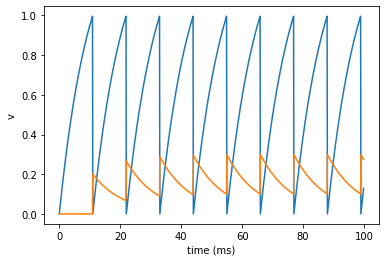

In [33]:
S = Synapses(G, G, on_pre='v += 0.2')
S.connect(i=0, j=1)
M = StateMonitor(G, 'v', record=True)
run(100*ms)
brian_plot(M)

In [34]:
start_scope()
eqs = '''
dv/dt = (I-v)/(10*ms) : 1
I : 1
'''
G = NeuronGroup(100, eqs,threshold='v>1',reset='v=0')
G.v= 'rand()' # This gives a random initial condition 
G.I='2' # i is the index of the Neuron N is the neuron number
spM = SpikeMonitor(G)


S = Synapses(G, G,'w:1')
S.connect(condition='i!=j and abs(i-j)<11') # the connects 10 neurons above and below each neuron

The plot below shows the connections of the 10 neurons above and below but not to itself.

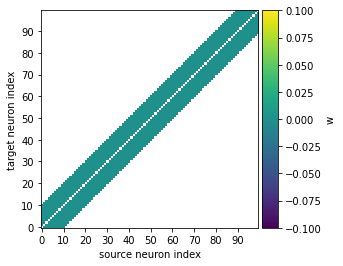

In [35]:
brian_plot(S.w)

### Adding Distance

The connections can even be describe by distance, $x$ such that only local neurons can be connected, the result is same as above but gives the connections a tangible quality.

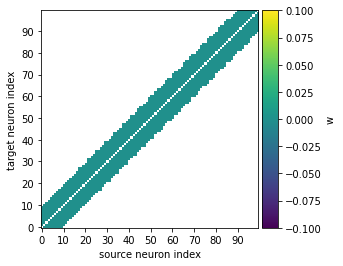

In [36]:
start_scope()
eqs = '''
dv/dt = (I-v)/(10*ms) : 1
I : 1
x:metre
'''
G = NeuronGroup(100, eqs,threshold='v>1',reset='v=0')
G.x='20*um*i'
G.v= 'rand()' # This gives a random initial condition 
G.I='2' # i is the index of the Neuron N is the neuron number


S = Synapses(G, G,'w:1')
S.connect(condition='i!=j and abs(x_pre-x_post)<200*um')#,p='exp(-(x_pre-x_post)**2/((100.0*um)**2.0))')
# Generator sytax good for large number of neurons

brian_plot(S.w)

## Including a probability of connections
To add a probabilistic aspect of the connections is simple by just adding in the arguement p= into **connect**.

WARNING    "I" is an internal variable of group "neurongroup_4", but also exists in the run namespace with the value 2.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


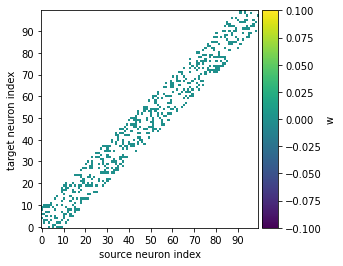

In [37]:
start_scope()
eqs = '''
dv/dt = (I-v)/(10*ms) : 1
I : 1
x:metre
'''
G = NeuronGroup(100, eqs,threshold='v>1',reset='v=0')
G.x='20*um*i'
G.v= 'rand()' # This gives a random initial condition 
G.I='2' # i is the index of the Neuron N is the neuron number
spM = SpikeMonitor(G)


S = Synapses(G, G,'w:1')
S.connect(condition='i!=j and abs(i-j)<10',p=0.3)

brian_plot(S.w)

## Addding a periodic weighting function

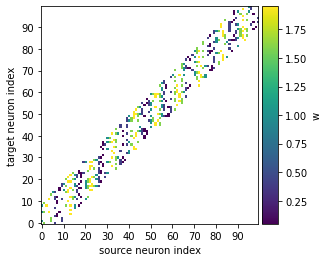

In [38]:
start_scope()
eqs = '''
dv/dt = (I-v)/(10*ms) : 1
I : 1
x:metre
'''
G = NeuronGroup(100, eqs,threshold='v>1',reset='v=0')
G.x='20*um*i'
G.v= 'rand()' # This gives a random initial condition 
G.I='2' # i is the index of the Neuron N is the neuron number
spM = SpikeMonitor(G)


S = Synapses(G, G,'w:1')
S.connect(condition='i!=j and abs(i-j)<10',p=0.3)



#
f=1/(200*um)
S.w='1+sin(2*pi*f*x_pre)'
brian_plot(S.w)

In [42]:
470/(1000/512)

240.64